<a href="https://colab.research.google.com/github/Henry-P-Ding/yquantum-2025/blob/main/henry_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install QuantumRingsLib
!pip install qiskit==1.3.1
!pip install quantumrings-toolkit-qiskit
!pip install pylatexenc

In [32]:
# Import the required modules
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import MultiplierGate, RGQFTMultiplier, ModularAdderGate, HalfAdderGate
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
import numpy as np

import QuantumRingsLib
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2
from quantumrings.toolkit.qiskit import QrJobV1

In [4]:
#Acquire the Quantum Rings Provider
provider = QuantumRingsProvider(
    token='rings-128.tFp5jv833mIYtWvhAcPilxZNHO0MGRw1',
    name='khang.tran@princeton.edu'
)
print("Account Name: ", provider.active_account()["name"], "\nMax Qubits: ", provider.active_account()["max_qubits"])


#Save the account locally.
provider.save_account(
    token='rings-128.tFp5jv833mIYtWvhAcPilxZNHO0MGRw1',
    name='khang.tran@princeton.edu')
print(provider.saved_accounts(False, "default"))

Account Name:  khang.tran@princeton.edu 
Max Qubits:  128
{'khang.tran@princeton.edu': 'rings-128.tFp5jv833mIYtWvhAcPilxZNHO0MGRw1'}


In [5]:
# controlled multipliers
def exponent(base, power, num_state_qubits):
    exp_gate = QuantumCircuit(2 * num_state_qubits)
    for i in range(base ** power):
        exp_gate.append(ModularAdderGate(num_state_qubits=num_state_qubits), range(2 * num_state_qubits))
    exp_gate.draw()
    return exp_gate.to_gate().control(1)

In [127]:
n = 4
n_N = 4

a = QuantumRegister(n, 'A')
b = QuantumRegister(n, 'B')
c = QuantumRegister(1, 'C')
ansi = AncillaRegister(n_N, 'ansi')
N = QuantumRegister(n_N, 'N')
output = ClassicalRegister(n)

rev_adder = QuantumCircuit(2 * n + 1)
rev_adder.append(HalfAdderGate(n), range(2 * n + 1))
rev_adder.inverse()
rev_adder = rev_adder.to_gate()

qc = QuantumCircuit(a, b, c, N, ansi, output)

qc.x([a[0], a[1]])
qc.x(b[2])
qc.x([N[0],N[2]])

# qc.append(HalfAdderGate(n), a[:] + b[:] + c[:])

qc.append(rev_adder, N[:] + b[:] + c[:])

# qc.x(c)

# qc.cswap(c, ansi[0], N[0])
# qc.cswap(c, ansi[1], N[1])
# qc.cswap(c, ansi[2], N[2])
# qc.cswap(c, ansi[3], N[3])

# qc.append(HalfAdderGate(n), N[:] + b[:] + c[:])

qc.measure(b, output)

qc.draw()

┌───┐                            
   A_0: ┤ X ├────────────────────────────
        ├───┤                            
   A_1: ┤ X ├────────────────────────────
        └───┘                            
   A_2: ─────────────────────────────────
                                         
   A_3: ─────────────────────────────────
             ┌──────────────┐┌─┐         
   B_0: ─────┤4             ├┤M├─────────
             │              │└╥┘┌─┐      
   B_1: ─────┤5             ├─╫─┤M├──────
        ┌───┐│              │ ║ └╥┘┌─┐   
   B_2: ┤ X ├┤6             ├─╫──╫─┤M├───
        └───┘│              │ ║  ║ └╥┘┌─┐
   B_3: ─────┤7             ├─╫──╫──╫─┤M├
             │              │ ║  ║  ║ └╥┘
     C: ─────┤8 circuit-529 ├─╫──╫──╫──╫─
        ┌───┐│              │ ║  ║  ║  ║ 
   N_0: ┤ X ├┤0             ├─╫──╫──╫──╫─
        └───┘│              │ ║  ║  ║  ║ 
   N_1: ─────┤1             ├─╫──╫──╫──╫─
        ┌───┐│              │ ║  ║  ║  ║ 
   N_2: ┤ X ├┤2             ├─╫──╫──╫──╫─
        └───┘│              │ ║  ║  ║  ║ 
   N_3: ─────┤3             ├─╫──╫──╫──╫─
             └──────────────┘ ║  ║  ║  ║ 
ansi_0: ──────────────────────╫──╫──╫──╫─
                              ║  ║  ║  ║ 
ansi_1: ──────────────────────╫──╫──╫──╫─
                              ║  ║  ║  ║ 
ansi_2: ──────────────────────╫──╫──╫──╫─
                              ║  ║  ║  ║ 
ansi_3: ──────────────────────╫──╫──╫──╫─
                              ║  ║  ║  ║ 
 c41: 4/══════════════════════╩══╩══╩══╩═
                              0  1  2  3

In [5]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        n (int):
                The number of qubits in the registers to use

    Returns:
        None

    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cp(-np.pi / 2** ( i -j + 1 ), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()
    return

In [10]:
num_size = 4
q = QuantumRegister(2 * num_size + 3, 'q')
c = ClassicalRegister(4 , 'c')
qc = QuantumCircuit(q, c)

# hadamard gates
qc.h(0)
qc.h(1)
qc.h(2)

# g_num = 3, start_num = 5
qc.x(6)
qc.draw()

qc.barrier()

# controlled multipliers
for power in range(1, num_size + 1):
    qc.append(exponent(7, power, num_size), [3 - power] + list(range(3, qc.num_qubits)) )

qc.barrier()

iqft_cct(qc, q, 3)

# measure target qubits
qc.measure(range(3), range(3))

qc.draw()

┌───┐ ░                                                     ░ ┌───┐»
 q_0: ┤ H ├─░──────────────────────────────────────────■──────────░─┤ H ├»
      ├───┤ ░                                          │          ░ └───┘»
 q_1: ┤ H ├─░─────────────────────────■────────────────┼──────────░──────»
      ├───┤ ░                         │                │          ░      »
 q_2: ┤ H ├─░────────■────────────────┼────────────────┼──────────░──────»
      └───┘ ░ ┌──────┴───────┐┌───────┴───────┐┌───────┴────────┐ ░      »
 q_3: ──────░─┤0             ├┤0              ├┤0               ├─░──────»
            ░ │              ││               ││                │ ░      »
 q_4: ──────░─┤1             ├┤1              ├┤1               ├─░──────»
            ░ │              ││               ││                │ ░      »
 q_5: ──────░─┤2             ├┤2              ├┤2               ├─░──────»
      ┌───┐ ░ │              ││               ││                │ ░      »
 q_6: ┤ X ├─░─┤3             ├┤3              ├┤3               ├─░──────»
      └───┘ ░ │  circuit-644 ││  circuit-3983 ││  circuit-27314 │ ░      »
 q_7: ──────░─┤4             ├┤4              ├┤4               ├─░──────»
            ░ │              ││               ││                │ ░      »
 q_8: ──────░─┤5             ├┤5              ├┤5               ├─░──────»
            ░ │              ││               ││                │ ░      »
 q_9: ──────░─┤6             ├┤6              ├┤6               ├─░──────»
            ░ │              ││               ││                │ ░      »
q_10: ──────░─┤7             ├┤7              ├┤7               ├─░──────»
            ░ └──────────────┘└───────────────┘└────────────────┘ ░      »
 c: 4/═══════════════════════════════════════════════════════════════════»
                                                                         »
«                                               ░ ┌─┐      
« q_0: ─■──────────────■────────────────────────░─┤M├──────
«       │P(-π/2) ┌───┐ │                        ░ └╥┘┌─┐   
« q_1: ─■────────┤ H ├─┼─────────■──────────────░──╫─┤M├───
«                └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║ └╥┘┌─┐
« q_2: ────────────────■─────────■────────┤ H ├─░──╫──╫─┤M├
«                                         └───┘ ░  ║  ║ └╥┘
« q_3: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_4: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_5: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_6: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_7: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_8: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« q_9: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
«q_10: ─────────────────────────────────────────░──╫──╫──╫─
«                                               ░  ║  ║  ║ 
« c: 4/════════════════════════════════════════════╩══╩══╩═
«                                                  0  1  2

In [128]:
# transpile circuit to Quantum Rings backend
qr_backend = QrBackendV2(provider, num_qubits = qc.num_qubits)
qc_transpiled = transpile(qc, qr_backend, initial_layout=[i for i in range(0, qc.num_qubits)])

In [129]:
# Execute the quantum code
job = qr_backend.run(qc_transpiled, shots = 1024)

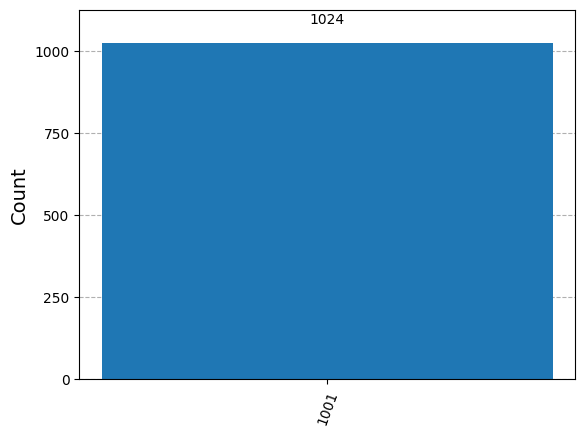

In [130]:
result = job.result()
counts = result.get_counts()
plot_histogram(counts)